## Attempt to use FAMD instead of PCA for dimensionality reduction to include the categorical variables in the dim reduction
Have not been able to get either prince of light-famd implementations working for FAMD so discarded this idea. Notebook kept in repo for completeness.

## Imports and Data Access

In [106]:
%pip install prince

Note: you may need to restart the kernel to use updated packages.


In [108]:
%pip install dython

Note: you may need to restart the kernel to use updated packages.


In [109]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import dython
from datetime import datetime as dt
from sklearn.preprocessing import quantile_transform, LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from prince import FAMD
from sklearn import metrics
import matplotlib.cm as cm

pd.set_option("max_columns", None)
pd.set_option("max_rows", None)

In [110]:
# Read in the data
df = pd.read_csv("marketing_campaign.csv", "\t")

## Exploratory Analysis

In [111]:
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  04-09-2012       58       635         88              546              172   
1  08-03-2014       38        11          1                6                2   
2  21-08-2013       26       426         49              127              111   
3  10-02-2014       26        11          4               20               10   
4  19-01-2014       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0

In [112]:
df.shape

(2240, 29)

In [113]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

There are a small number of nulls in the income column (24). I have no way of knowing whether these are customers who have no income or whether the data is missing. For this reason, I will decide not to lose any data, and I will replace the nulls with zeros as this is a valid scenario.


In [114]:
# Check for any NaNs and replace with zeros
df.Income = df.Income.fillna(0)

In [115]:
df.describe()

index            ID   Year_Birth         Income      Kidhome  \
count  2216.000000   2216.000000  2216.000000    2216.000000  2216.000000   
mean   1121.867329   5588.353339  1968.820397   52247.251354     0.441787   
std     643.164161   3249.376275    11.985554   25173.076661     0.536896   
min       0.000000      0.000000  1893.000000    1730.000000     0.000000   
25%     566.750000   2814.750000  1959.000000   35303.000000     0.000000   
50%    1120.500000   5458.500000  1970.000000   51381.500000     0.000000   
75%    1678.250000   8421.750000  1977.000000   68522.000000     1.000000   
max    2239.000000  11191.000000  1996.000000  666666.000000     2.000000   

          Teenhome      Recency     MntWines    MntFruits  MntMeatProducts  \
count  2216.000000  2216.000000  2216.000000  2216.000000      2216.000000   
mean      0.505415    49.012635   305.091606    26.356047       166.995939   
std       0.544181    28.948352   337.327920    39.793917       224.283273   
min       0.000000     0.000000     0.000000     0.000000         0.000000   
25%       0.000000    24.000000    24.000000     2.000000        16.000000   
50%       0.000000    49.000000   174.500000     8.000000        68.000000   
75%       1.000000    74.000000   505.000000    33.000000       232.250000   
max       2.000000    99.000000  1493.000000   199.000000      1725.000000   

       MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
count      2216.000000       2216.000000   2216.000000        2216.000000   
mean         37.637635         27.028881     43.965253           2.323556   
std          54.752082         41.072046     51.815414           1.923716   
min           0.000000          0.000000      0.000000           0.000000   
25%           3.000000          1.000000      9.000000           1.000000   
50%          12.000000          8.000000     24.500000           2.000000   
75%          50.000000         33.000000     56.000000           3.000000   
max         259.000000        262.000000    321.000000          15.000000   

       NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
count      2216.000000          2216.000000        2216.000000   
mean          4.085289             2.671029           5.800993   
std           2.740951             2.926734           3.250785   
min           0.000000             0.000000           0.000000   
25%           2.000000             0.000000           3.000000   
50%           4.000000             2.000000           5.000000   
75%           6.000000             4.000000           8.000000   
max          27.000000            28.000000          13.000000   

       NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
count        2216.000000   2216.000000   2216.000000   2216.000000   
mean            5.319043      0.073556      0.074007      0.073105   
std             2.425359      0.261106      0.261842      0.260367   
min             0.000000      0.000000      0.000000      0.000000   
25%             3.000000      0.000000      0.000000      0.000000   
50%             6.000000      0.000000      0.000000      0.000000   
75%             7.000000      0.000000      0.000000      0.000000   
max            20.000000      1.000000      1.000000      1.000000   

       AcceptedCmp1  AcceptedCmp2     Complain  Z_CostContact  Z_Revenue  \
count   2216.000000   2216.000000  2216.000000         2216.0     2216.0   
mean       0.064079      0.013538     0.009477            3.0       11.0   
std        0.244950      0.115588     0.096907            0.0        0.0   
min        0.000000      0.000000     0.000000            3.0       11.0   
25%        0.000000      0.000000     0.000000            3.0       11.0   
50%        0.000000      0.000000     0.000000            3.0       11.0   
75%        0.000000      0.000000     0.000000            3.0       11.0   
max        1.000000      1.000000     1.000000            3.0       11.0   

          R

### Explore binary feature distributions

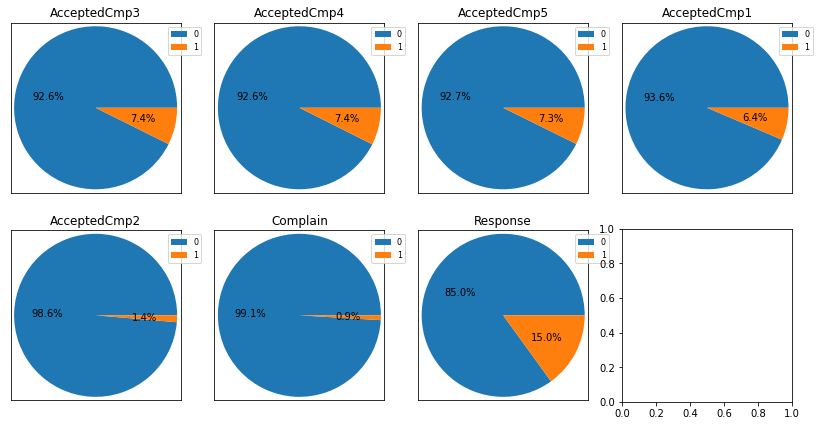

In [116]:
b_feature_names = [col for col in df if df[col].dropna().value_counts().index.isin([0,1]).all()]
b_feature_count = len(b_feature_names)

# determine required rows and columns
b_column_count = 4
b_row_count = math.ceil(b_feature_count / b_column_count)

 
# configure figure layout
fig, ax = plt.subplots(b_row_count, b_column_count, figsize =(b_column_count * 3.5, b_row_count * 3.5))

 
# render distribution of each feature
for k in range(0,b_feature_count):
  
  # determine row & col position
    b_col = k % b_column_count
    b_row = int(k / b_column_count)
    
  # determine feature to be plotted
    f = b_feature_names[k]
    value_counts = df[f].value_counts()

  # render pie chart
    ax[b_row][b_col].pie(
    x = value_counts.values,
    labels = value_counts.index,
    explode = None,
    autopct='%1.1f%%',
    labeldistance=None,
    #pctdistance=0.4,
    frame=True,
    radius=0.48,
    center=(0.5, 0.5)
    )

  # clear frame of ticks
    ax[b_row][b_col].set_xticks([])
    ax[b_row][b_col].set_yticks([])

  # legend & feature name
    ax[b_row][b_col].legend(bbox_to_anchor=(0.9,1),loc='upper left', fontsize=8)
    ax[b_row][b_col].set_title(f"{b_feature_names[k]}")

### Explore continuous feature distributions

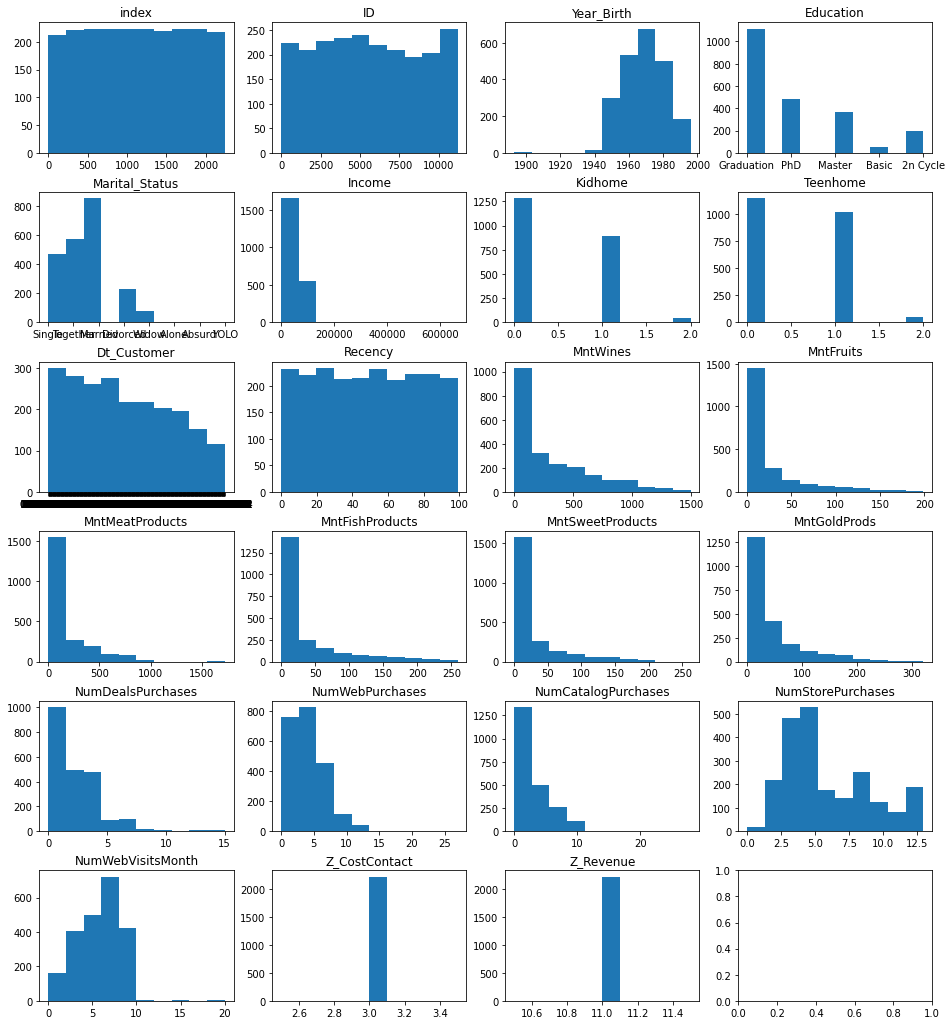

In [117]:
c_feature_names = [col for col in df.columns if col not in b_feature_names]
feature_count = len(c_feature_names)
 
# determine required rows and columns for visualizations
column_count = 4
row_count = math.ceil(feature_count / column_count)

# configure figure layout
fig, ax = plt.subplots(row_count, column_count, figsize =(column_count * 4, row_count * 3))

# render distribution of each feature
for k in range(0,feature_count):
  # determine row & col position
    col = k % column_count
    row = int(k / column_count)

  # set figure at row & col position
    ax[row][col].hist(df[c_feature_names[k]], rwidth=1, bins=10) # histogram
    #ax[row][col].set_xlim(0,1)   # set x scale
    #ax[row][col].set_ylim(0,df.shape[0]) # set y scale 
    ax[row][col].set_title(f"{c_feature_names[k]}")   # feature name in chart
    plt.subplots_adjust(hspace=0.3)

It appeats as though we have features here that can be split in to four broad categories. 
- Person - this is mainly demographic information about the customer
- Product - this is data on the amount a customer spent on specific product groups
- Promotion - this is data on how the customer interacts with promotional activity / marketing campaigns
- Place - this is data on where / how the customer makes their purchases 

We can also see above that there are two featurs, Z_CostContact and Z_Revenue which appear just to be constant. We will drop these from our features, and we will now try to extract further value from the remaining features. So, for example, I will create an age feature from the Year of Birth data we havea and I will combine all product spend into a Total_Spend feature, among other things. 

In [118]:
# Drop Z_CostContact and Z_Revenue as they appear to just be constants
df = df.drop(["Z_CostContact", "Z_Revenue"], axis=1)

## Feature Engineering

In [119]:
# Define the year today
today_year = dt.today().year
today_date = dt.today()

# Create age feature
df['age'] = today_year - df['Year_Birth']

# Create has_child feature
df['has_child'] = np.where(df['Kidhome'] > 0, 1, 0)

# Create a total_spend feature
df['total_spend'] = df['MntWines']+ df['MntFruits']+ df['MntMeatProducts']+ df['MntFishProducts']+ df['MntSweetProducts']+ df['MntGoldProds']

# Create a total_number_purchases feature
df['total_purchases'] = df['NumWebPurchases']+ df['NumCatalogPurchases']+ df['NumStorePurchases']

# Replace number of purchases with fraction of purchases by location and fraction of purchase w/deals
df['purchases_with_deals'] = df["NumDealsPurchases"]/df['total_purchases']
df['web_purchase_fraction'] = df["NumWebPurchases"]/df['total_purchases']
df['catalog_purchase_fraction'] = df["NumCatalogPurchases"]/df['total_purchases']
df['store_purchase_fraction'] = df["NumStorePurchases"]/df['total_purchases']

# Combine the Accepted Promos into a Count
df["promos_accepted"] = df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] + df["AcceptedCmp4"] + df["AcceptedCmp5"] + df["Response"]

# Is it worth grouping marital statuses together? 
df["Marital_Status"] = df["Marital_Status"].replace({'Divorced':'Single', 'Single':'Single', 'Alone':'Single', 'Widow':'Single', 'Absurd':'Single', 'YOLO':'Single','Married':'Married','Together':'Married'})

# Deal with the date of customer's enrolment (create tenure)
today_date = dt.today()
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['tenure'] = (today_date - df['Dt_Customer']).dt.days

# Improve education groupings
df['Education']=df['Education'].replace({'Basic':'Basic','2n Cycle':'Postgrad','Graduation':'Bachelor','Master':'Postgrad','PhD':'Postgrad'})


In [120]:
# Check for any NaNs and replace with zeros
df = df.fillna(0)

In [121]:
# Check for any data quality issues / zero division errors caused above
df.iloc[df.values==np.inf]

index    ID  Year_Birth Education Marital_Status  Income  Kidhome  \
1232   1245  6862        1971  Bachelor         Single  1730.0        0   
1829   1846  9931        1963  Postgrad        Married  4023.0        1   

      Teenhome Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  \
1232         0  2014-05-18       65         1          1                3   
1829         1  2014-06-23       29         5          0                1   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
1232                1                 1             1                 15   
1829                1                 1             1                 15   

      NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
1232                0                    0                  0   
1829                0                    0                  0   

      NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
1232                 20             0             0             0   
1829                 19             0             0             0   

      AcceptedCmp1  AcceptedCmp2  Complain  Response  age  has_child  \
1232             0             0         0         0   51          0   
1829             0             0         0         0   59          1   

      total_spend  total_purchases  purchases_with_deals  \
1232            8                0                   inf   
1829            9                0                   inf   

      web_purchase_fraction  catalog_purchase_fraction  \
1232                    0.0                        0.0   
1829                    0.0                        0.0   

      store_purchase_fraction  promos_accepted  tenure  
1232                      0.0                0    2804  
1829                      0.0                0    2768

In [122]:
## Some data quality issues arise with some of the feature creation above
# NumDealsPurchases = 15 but total_purchases = 0, giving np.inf datatype which cannot be used
# As I believe this to be a data quality issue I will drop these instances
df.drop([1232, 1829], axis=0, inplace=True)
df.iloc[df.values==np.inf]

Empty DataFrame
Columns: [index, ID, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Response, age, has_child, total_spend, total_purchases, purchases_with_deals, web_purchase_fraction, catalog_purchase_fraction, store_purchase_fraction, promos_accepted, tenure]
Index: []

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2214 entries, 0 to 2215
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   index                      2214 non-null   int64         
 1   ID                         2214 non-null   int64         
 2   Year_Birth                 2214 non-null   int64         
 3   Education                  2214 non-null   object        
 4   Marital_Status             2214 non-null   object        
 5   Income                     2214 non-null   float64       
 6   Kidhome                    2214 non-null   int64         
 7   Teenhome                   2214 non-null   int64         
 8   Dt_Customer                2214 non-null   datetime64[ns]
 9   Recency                    2214 non-null   int64         
 10  MntWines                   2214 non-null   int64         
 11  MntFruits                  2214 non-null   int64         
 12  MntMea

In [124]:
# Select just relevant colums
df_ID = df['ID']
df = df.drop(["index", "ID", "Year_Birth", "Kidhome", "Teenhome", "Dt_Customer", "MntWines", "MntFruits",
              "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds", "NumDealsPurchases", 
              "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases", "AcceptedCmp1", "AcceptedCmp2",
              "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"], axis=1)

### Encoding - NOT REQUIRED if using FAMD

In [125]:
# le = LabelEncoder()
# cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
# for i in cat_cols:
#     df[i] = le.fit_transform(df[[i]])

In [127]:
# Re-Run Identification of Binary / Continious Features and Add Categorical to Binary Features
b_feature_names = [col for col in df if df[col].dropna().value_counts().index.isin([0,1]).all()]
cat_feature_names = set(b_feature_names + ["Education", "Marital_Status"])
c_feature_names = [col for col in df.columns if col not in cat_feature_names]

In [128]:
df_cat = df[cat_feature_names]
df_cat.has_child.replace((1,0), ('yes', 'no'), inplace=True)
df_cat.Complain.replace((1,0), ('yes', 'no'), inplace=True)
df_cat


has_child Complain Marital_Status Education
0           no       no         Single  Bachelor
1          yes       no         Single  Bachelor
2           no       no        Married  Bachelor
3          yes       no        Married  Bachelor
4          yes       no        Married  Postgrad
5           no       no        Married  Postgrad
6           no       no         Single  Bachelor
7          yes       no        Married  Postgrad
8          yes       no        Married  Postgrad
9          yes       no        Married  Postgrad
10          no       no        Married     Basic
11          no       no         Single  Bachelor
12         yes       no         Single  Postgrad
13          no       no        Married  Bachelor
14          no       no         Single  Postgrad
15         yes       no        Married  Bachelor
16          no       no        Married  Bachelor
17          no       no        Married  Postgrad
18         yes       no         Single  Postgrad
19          no       no        Married  Bachelor
20         yes       no        Married  Bachelor
21          no       no        Married  Postgrad
22          no       no        Married  Postgrad
23          no       no        Married  Bachelor
24          no       no         Single  Bachelor
25         yes       no        Married  Bachelor
26         yes       no        Married  Bachelor
27          no       no        Married  Postgrad
28          no       no         Single  Postgrad
29          no       no        Married  Postgrad
30          no       no        Married  Bachelor
31          no       no         Single  Postgrad
32          no       no        Married  Postgrad
33         yes       no         Single  Postgrad
34          no       no        Married  Postgrad
35         yes       no        Married  Postgrad
36          no       no         Single  Bachelor
37          no       no         Single  Postgrad
38          no       no        Married  Bachelor
39         yes       no        Married  Postgrad
40          no       no        Married  Bachelor
41         yes       no        Married  Postgrad
42          no       no         Single  Bachelor
43          no       no        Married  Postgrad
44         yes       no        Married  Bachelor
45         yes       no        Married  Postgrad
46          no       no         Single  Bachelor
47          no       no        Married  Postgrad
48         yes       no         Single  Bachelor
49          no       no         Single  Bachelor
50         yes       no        Married  Bachelor
51          no       no        Married  Postgrad
52          no       no         Single  Bachelor
53         yes       no         Single  Bachelor
54          no       no        Married  Postgrad
55          no       no         Single  Postgrad
56         yes       no        Married  Bachelor
57          no       no         Single  Bachelor
58          no       no         Single  Postgrad
59          no       no        Married  Bachelor
60         yes       no        Married  Bachelor
61         yes       no        Married  Bachelor
62          no       no         Single  Postgrad
63          no       no        Married  Bachelor
64         yes       no        Married  Bachelor
65          no       no        Married  Postgrad
66          no       no        Married  Bachelor
67         yes       no        Married  Postgrad
68          no       no        Married  Bachelor
69         yes       no         Single  Bachelor
70          no       no        Married  Postgrad
71          no       no         Single  Bachelor
72          no      yes        Married  Postgrad
73          no       no        Married  Bachelor
74         yes       no         Single  Bachelor
75         yes       no        Married  Bachelor
76         yes       no        Married  Postgrad
77          no       no        Married  Postgrad
78          no       no         Single  Bachelor
79         yes       no        Married  Bachelor
80         yes       no        Marri

### Scale Continuous Features

In [129]:
# access continous features
cont_features = df[c_feature_names]

# apply quantile transform
qc_features = pd.DataFrame(
  quantile_transform(cont_features, output_distribution='normal', ignore_implicit_zeros=True),
  columns=cont_features.columns,
  copy=True)

# show transformed data
qc_features

Income   Recency  NumWebVisitsMonth       age  total_spend  \
0     0.239935  0.245840           0.574595  0.846279     1.398646   
1    -0.185480 -0.275694          -0.212353  1.118711    -1.486537   
2     0.830752 -0.615025          -0.513491  0.341493     0.370435   
3    -1.145572 -0.615025           0.137177 -1.242061    -0.895780   
4     0.244412  1.634747          -0.212353 -0.981540     0.041353   
5     0.400658 -0.949547           0.137177  0.213636     0.316197   
6     0.149143 -0.374936           0.137177 -0.082896     0.214802   
7    -0.777943 -0.422483           1.184447 -1.331018    -0.305728   
8    -0.948048 -0.846279           1.994971 -0.346817    -1.012474   
9    -2.854652  0.493553           5.199338  1.593219    -0.943656   
10   -2.456904  0.261387           1.184447 -0.551076    -0.776528   
11    0.431215  0.959440          -1.186981  0.697507     0.741388   
12    0.284914  0.098013           0.137177  1.321946    -0.096753   
13   -1.785942 -0.275694           1.184447 -1.558482    -1.012474   
14    1.546260 -0.723343          -0.810910  2.169694     1.002083   
15   -0.371181  0.046436           1.184447 -0.914679    -0.492137   
16   -0.543789 -0.809168           0.574595  2.169694    -0.079120   
17    1.098318  1.381364          -0.212353  1.727466     1.654145   
18   -0.757328  1.125776           0.137177 -1.331018    -0.383024   
19   -0.582921 -0.202098           1.184447 -1.061884    -0.081638   
20   -5.199338 -0.180377          -1.773922 -0.837338     1.588771   
21    0.260353  0.358833           1.184447  1.727466     0.577285   
22    0.529568 -5.199338          -0.513491  1.118711     0.172731   
23   -0.414135  0.519225           1.184447  1.464186     0.074087   
24   -1.711865  1.272478           0.574595  0.089192    -0.621099   
25    0.061317 -1.597698           0.574595 -0.551076    -0.177827   
26   -0.517823 -0.615025          -0.810910 -1.824556    -0.389783   
27    1.681614  1.858747          -1.186981  0.341493     1.481899   
28   -2.203943 -0.374936          -0.212353 -1.824556    -1.404533   
29   -0.496533  0.189310          -0.810910  0.464007    -0.076604   
30   -0.420519 -0.445919          -0.212353  0.007527    -0.421111   
31   -0.175278 -1.352623           0.137177  1.321946    -0.105349   
32    0.677211 -1.597698           0.574595  2.169694     0.877196   
33   -0.080087  0.156199           0.574595  1.464186    -0.721714   
34    0.622464 -0.303168          -1.186981  0.007527     0.513252   
35   -1.310199  0.729877           0.574595 -0.551076    -0.570161   
36   -0.336845  5.199338          -0.212353 -0.263985    -0.699108   
37   -0.094232  0.098013           0.137177  2.696511     0.493553   
38    1.295416 -1.721914          -0.513491 -0.914679     1.111356   
39   -1.541296  1.228607           1.184447 -1.331018    -0.895780   
40   -1.468668 -1.597698          -0.212353  0.846279    -1.669112   
41   -2.456904 -0.846279          -0.212353 -0.439001    -1.374878   
42    1.291286  0.610484          -1.773922 -0.551076     0.597989   
43   -2.456904 -0.681594           1.994971 -5.199338    -0.410169   
44   -0.373854  1.453280           2.651732  0.158740    -0.853480   
45    0.892098 -0.249721           1.184447  1.118711     1.010382   
46    0.537964 -0.516356          -1.186981  0.846279     0.147316   
47    1.231237 -1.887753          -0.810910  0.412900     1.530839   
48   -0.652929  0.125788           0.574595 -0.645631    -0.639462   
49    1.523081  0.125788          -1.773922 -0.645631     1.398646   
50    0.579039  0.222630          -0.810910 -0.738089     0.227777   
51    1.499409  0.156199          -1.773922  1.023003     1.959536   
52    0.757713 -0.476619          -0.810910  0.269184     0.726178   
53   -1.066187 -0.445919          -0.810910 -1.674186    -1.431971   
54    0.159991  0.358833           0.574595  0.158740     0.151883   
55    1.042435 -1.111702          -1.773922 -1.061884     1.145618   
56    0.595082 -0.

In [130]:
qc_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214 entries, 0 to 2213
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Income                     2214 non-null   float64
 1   Recency                    2214 non-null   float64
 2   NumWebVisitsMonth          2214 non-null   float64
 3   age                        2214 non-null   float64
 4   total_spend                2214 non-null   float64
 5   total_purchases            2214 non-null   float64
 6   purchases_with_deals       2214 non-null   float64
 7   web_purchase_fraction      2214 non-null   float64
 8   catalog_purchase_fraction  2214 non-null   float64
 9   store_purchase_fraction    2214 non-null   float64
 10  promos_accepted            2214 non-null   float64
 11  tenure                     2214 non-null   float64
dtypes: float64(12)
memory usage: 207.7 KB


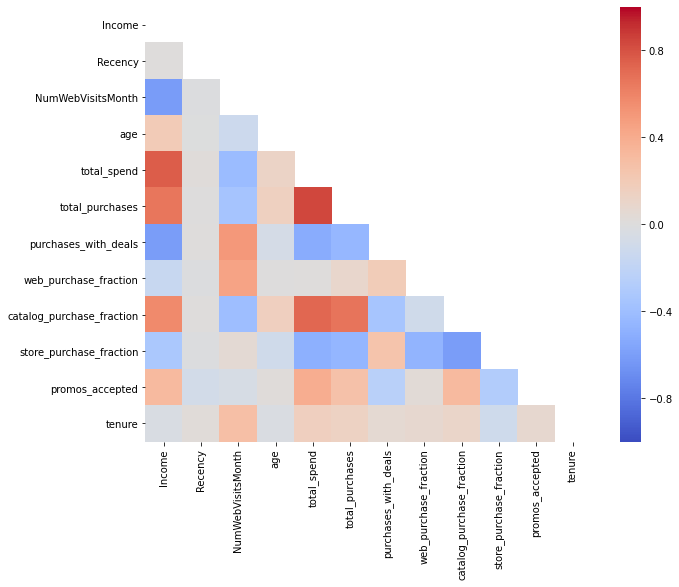

In [131]:
# Get correlation matrix
qc_features_corr = qc_features.corr() 

# use a mask to remove top-half of heatmap
top_mask = np.zeros(qc_features_corr.shape, dtype=bool)
top_mask[np.triu_indices(len(top_mask))] = True

plt.figure(figsize=(10,8))

# Plot heatmap
hmap = sns.heatmap(
  qc_features_corr,
  cmap = 'coolwarm',
  vmin =  1.0, 
  vmax = -1.0,
  mask = top_mask
  )

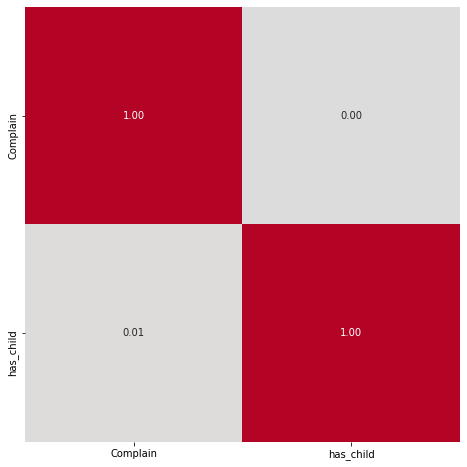

In [132]:
# Look at correlations between binary variables with Theil's U

_ = dython.nominal.associations(
  df[b_feature_names], 
  nominal_columns='all',
  nom_nom_assoc='theil',
  figsize=(10,8),
  cmap='coolwarm',
  vmax=1.0,
  vmin=0.0,
  cbar=False
  )

## Apply Dimensionality Reduction

In [133]:
# First add back in categorical data to continuous data
data = (
  pd.concat( 
    [qc_features, df_cat],
    axis=1
    )
  )

data.dropna(axis=0, how='any', inplace=True)
data.reset_index(inplace=True)
data_ID = data['index']
data.drop('index', axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Income                     2212 non-null   float64
 1   Recency                    2212 non-null   float64
 2   NumWebVisitsMonth          2212 non-null   float64
 3   age                        2212 non-null   float64
 4   total_spend                2212 non-null   float64
 5   total_purchases            2212 non-null   float64
 6   purchases_with_deals       2212 non-null   float64
 7   web_purchase_fraction      2212 non-null   float64
 8   catalog_purchase_fraction  2212 non-null   float64
 9   store_purchase_fraction    2212 non-null   float64
 10  promos_accepted            2212 non-null   float64
 11  tenure                     2212 non-null   float64
 12  has_child                  2212 non-null   object 
 13  Complain                   2212 non-null   objec

In [135]:
variance_ratio = {}

for i in range(1, len(data.columns)+1):
    famd = FAMD(n_components=i)
    famd.fit(data)
    variance_ratio[f'n_{i}'] = famd.explained_inertia_.sum()
    
variance_ratio

{'n_1': 0.2043068417277786,
 'n_2': 0.3221360181564974,
 'n_3': 0.4374539431707605,
 'n_4': 0.529438055708363,
 'n_5': 0.617999629567701,
 'n_6': 0.7013128285184108,
 'n_7': 0.7728668708546759,
 'n_8': 0.8143623132242199,
 'n_9': 0.8553422086211158,
 'n_10': 0.8924221798824337,
 'n_11': 0.9231795037333851,
 'n_12': 0.9481974300845347,
 'n_13': 0.9678386881273977,
 'n_14': 0.9808283128741264,
 'n_15': 0.9899371460883604,
 'n_16': 0.9951171366255274}

In [141]:
famd = FAMD(n_components=8, random_state=42)
famd.fit(data)
data_famd = pd.DataFrame(famd.transform(data), 
                        columns = (["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"]))

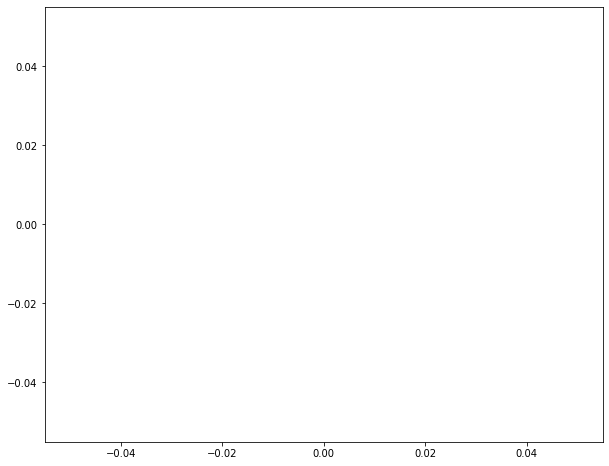

In [142]:
fig, ax = plt.subplots(figsize=(10,8))

_ = sns.scatterplot(
  data=data_famd,
  x='PC1',
  y='PC2',
  alpha=0.5,
  ax=ax
  )

In [144]:
ax = famd.plot_row_coordinates(
data_famd,
ax=None,
figsize=(6, 6),
x_component=0,
y_component=1,
labels=data_famd.index,
color_labels=['Oak type {}'.format(t) for t in data_famd['Oak type']],
ellipse_outline=False,
ellipse_fill=True,
show_points=True
)

NameError: name 'X' is not defined

## Apply KMeans

In [143]:
results = []

# train models with n number of clusters
for n in range(2,10): # evaluate 2 to 12 clusters
        # fit the algorithm with n clusters
    model = KMeans(n_clusters=n)
    clusters = model.fit(data_famd).labels_
        # capture the inertia & silhouette scores for this value of n
    results += [(n, metrics.silhouette_score(data_famd, clusters))]

results_pd = pd.DataFrame(results, columns=['n', 'silhouette'])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

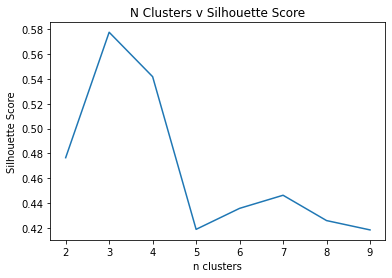

In [197]:
plt.plot(results_pd['n'], results_pd['silhouette'])
plt.xlabel('n clusters')
plt.ylabel('Silhouette Score')
plt.title('N Clusters v Silhouette Score')
plt.show()

In [198]:
X = data_pca
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

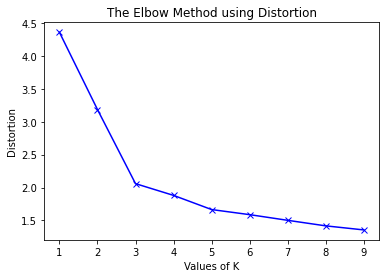

In [199]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

The above charts indicate that 3 clusters is the best option for this problem, so let's train the model with 3 clusters. 

In [200]:
n = 3
 
# configure model
best_model_km = KMeans( n_clusters=n)

# train and predict clusters
best_clusters_km = best_model_km.fit(X).labels_

# score results
best_score_km = metrics.silhouette_score(X, best_clusters_km)

# print best score obtained
print('Silhouette Score: {0:.6f}'.format(best_score_km))

# combine households with cluster assignments
best_labeled_X_df_km = (
  pd.concat( 
    [X, pd.DataFrame(best_clusters_km,columns=['cluster'])],
    axis=1
    )
  )

Silhouette Score: 0.577698


In [201]:
# modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def plot_silhouette_chart(features, labels):
  
      n = len(np.unique(labels))

      # configure plot area
      fig, ax = plt.subplots(1, 1)
      fig.set_size_inches(8, 5)

      # configure plots for silhouette scores between -1 and 1
      ax.set_xlim([-0.1, 1])
      ax.set_ylim([0, len(features) + (n + 1) * 10])

      # avg silhouette score
      score = metrics.silhouette_score(features, labels)

      # compute the silhouette scores for each sample
      sample_silhouette_values = metrics.silhouette_samples(features, labels)

      y_lower = 10

      for i in range(n):

          # get and sort members by cluster and score
          ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
          ith_cluster_silhouette_values.sort()

          # size y based on sample count
          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          # pretty up the charts
          color = cm.nipy_spectral(float(i) / n)

          ax.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

          # label the silhouette plots with their cluster numbers at the middle
          ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

          # compute the new y_lower for next plot
          y_lower = y_upper + 10  # 10 for the 0 samples


      ax.set_title("Average silhouette of {0:.3f} with {1} clusters".format(score, n))
      ax.set_xlabel("The silhouette coefficient values")
      ax.set_ylabel("Cluster label")

      # vertical line for average silhouette score of all the values
      ax.axvline(x=score, color="red", linestyle="--")

      ax.set_yticks([])  # clear the yaxis labels / ticks
      ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

      return fig, ax

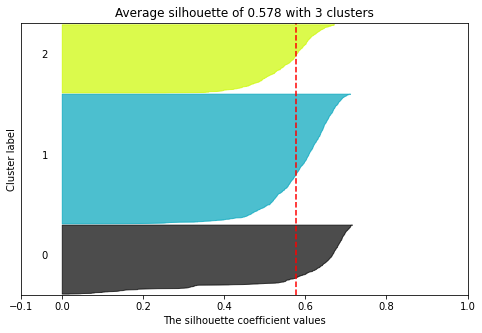

In [202]:
_ = plot_silhouette_chart(X, best_clusters_km)

## Apply Hierarchical Clustering

In [203]:
results = []

# train models with n number of clusters * linkages
for a in ['ward']:  # linkages

    for n in range(2,10): # evaluate 2 to 9 clusters

    # fit the algorithm with n clusters
        model = AgglomerativeClustering(n_clusters=n, linkage=a)
        clusters = model.fit(X).labels_

    # capture the inertia & silhouette scores for this value of n
        results += [ (n, a, metrics.silhouette_score(X, clusters)) ]

 
results_pd = pd.DataFrame(results, columns=['n', 'linkage', 'silhouette'])

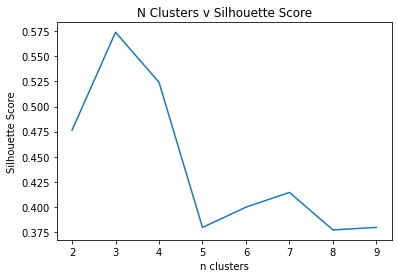

In [204]:
plt.plot(results_pd['n'], results_pd['silhouette'])
plt.xlabel('n clusters')
plt.ylabel('Silhouette Score')
plt.title('N Clusters v Silhouette Score')
plt.show()

In [205]:
n = 3
 
# configure model
best_model_hc = AgglomerativeClustering( n_clusters=n)

# train and predict clusters
best_clusters_hc = best_model_hc.fit(X).labels_

# score results
best_score_hc = metrics.silhouette_score(X, best_clusters_hc)

# print best score obtained
print('Silhouette Score: {0:.6f}'.format(best_score_hc))

# combine households with cluster assignments
best_labeled_X_df_hc = (
  pd.concat( 
    [X, pd.DataFrame(best_clusters_hc,columns=['cluster'])],
    axis=1
    )
  )

Silhouette Score: 0.574107


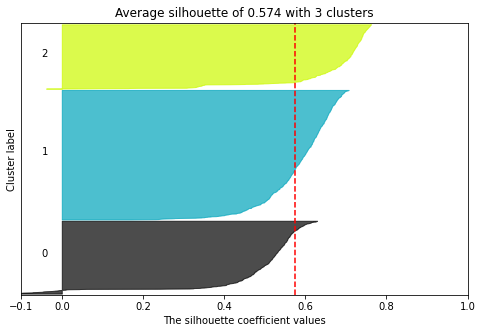

In [206]:
_ = plot_silhouette_chart(X, best_clusters_hc)

## Profiling

Using the best result which was the KMeans algorithm for 3 clusters using data pre-processed with PCA, I will profile the resulting clusters.

In [213]:
best_labeled_X_df_km

PC1       PC2       PC3        PC4  cluster
0     5.750768 -0.874727 -1.975560  -0.269842        2
1    -0.965201  1.822767  0.012890  -1.824680        1
2    -0.117478  2.107451  0.240870   1.463757        1
3    -4.641238 -1.764206  0.808171   0.890034        0
4    -0.295718  2.218245 -0.769349  -0.486586        1
5     0.041566  2.292846  0.041655   0.256478        1
6    -0.143206  2.078982 -1.325494   0.100115        1
7    -4.172170 -1.687129 -1.144692   1.823337        0
8    -0.331611 -6.471233 -2.061775   1.753242        0
9    -1.002968 -7.334610 -8.310379   1.318038        0
10   -4.748960 -1.987688 -0.821928   0.465918        0
11    0.425679  2.947073  1.401849  -0.215368        1
12   -0.733477  1.628660 -1.340292   0.849144        1
13   -4.980227 -2.133719  0.352696  -0.461848        0
14    5.834033 -1.950701  1.223105   1.061045        2
15   -4.337546 -1.763615 -1.619954   1.121163        0
16   -0.930596  1.459448 -0.865659  -0.264637        1
17    4.759903 -1.622248 -0.600913   1.407405        2
18   -0.948946  1.574681 -1.265987  -1.625819        1
19   -0.519160  1.687059 -1.454884  -0.577557        1
20    3.413327  5.836418 -0.960335  -4.951281        1
21    3.691926 -2.340750  0.788004  -1.857123        2
22   -0.396244  1.729686  0.620634   1.050654        1
23   -1.097150  1.269902 -2.969746  -0.054896        1
24   -1.220934  1.442291 -1.320707  -1.667136        1
25   -0.913241  1.289812 -1.986326   0.119194        1
26   -0.981056  1.565455  0.142062  -1.084540        1
27    5.785150 -0.509751  1.572790   0.851248        2
28   -4.722357 -1.901990 -0.751241   1.233865        0
29    1.071813  3.480168  0.045598  -1.126652        1
30    3.071518 -2.916564  0.041205  -1.598742        2
31    2.863246 -3.181204 -0.796647  -1.420459        2
32    0.621383  2.805774  0.727058  -0.291545        1
33   -4.178224 -1.439875  0.229618   1.660806        0
34    0.460716  2.903831  1.055430  -0.242707        1
35   -1.049202  1.408889 -2.829959  -1.017574        1
36   -1.163119  1.999059  0.761102  -2.003013        1
37    5.906893 -1.266828 -1.081824  -0.327448        2
38    1.205673  3.065449 -1.027672   1.172694        1
39   -4.841567 -1.958836 -0.632941   0.393290        0
40   -5.673465 -2.121636  5.444945  -3.334206        0
41   -5.046894 -2.074847 -0.802462  -0.358414        0
42    0.449404  3.025142  2.588259  -0.161950        1
43    2.350177 -3.911626 -2.749907  -2.559959        2
44   -4.518889 -1.917173 -1.732595   1.377142        0
45   -0.602974  1.726091 -0.585330  -0.814266        1
46   -0.427310  2.159524  2.043592   0.740819        1
47    1.715981  3.634107  1.172492   1.227793        1
48   -4.471635 -1.725197 -0.399343   0.724220        0
49    6.492541 -1.177894  1.945455   0.220232        2
50   -0.757337  1.866652  0.717254  -0.839597        1
51    6.375963 -0.749612  2.501753   0.243131        2
52    4.642303 -1.633123  1.126996  -0.022830        2
53   -4.795607 -1.711739  2.464653   0.165229        0
54   -0.446746  1.813779 -1.549759   0.959051        1
55    5.611533 -2.010931  2.396886  -0.463271        2
56   -0.544007  1.897701  0.917318  -0.724582        1
57   -0.425148  1.823885 -0.849962   0.544040        1
58    0.130479  2.319572 -0.048298   1.183719        1
59    0.874791  2.940093 -1.178137   1.434431        1
60    2.978845 -2.849917 -0.286536  -2.538174        2
61   -5.116462 -2.395954  0.884517   0.701271        0
62    6.465092 -1.585045  0.563047   1.910611        2
63   -0.285515  2.015362  0.898848   0.720634        1
64    0.744825  3.221817 -0.181691  -1.934461        1
65    1.439821  3.519484 -0.041090  -0.436548        1
66   -0.113323  2.083642 -0.677652   0.813057        1
67    3.474124 -2.725732 -1.294573   0.059298        2
68   -0.933606  1.828863  0.725164  -0.466006        1
69   -4.986352 -1.984041  0.360070   0.020775        0
70    5.430275 -1.214957 -0.730718   0.547295        2
71    6.672340 -0.920382  2.229189   2.139681      

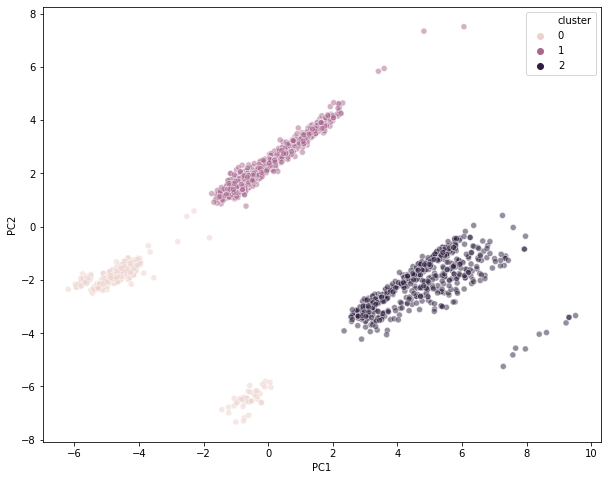

In [214]:
fig, ax = plt.subplots(figsize=(10,8))

_ = sns.scatterplot(
    data=best_labeled_X_df_km,
    x='PC1',
    y='PC2',
    hue='cluster',
    alpha=0.5,
    ax=ax
      )

In [215]:
df_km = (
  pd.concat( 
    [df, pd.DataFrame(best_clusters_km,columns=['cluster'])],
    axis=1
    )
  )

df_km

Education  Marital_Status    Income  Recency  NumWebVisitsMonth  \
0           0.0             1.0   58138.0     58.0                7.0   
1           0.0             1.0   46344.0     38.0                5.0   
2           0.0             0.0   71613.0     26.0                4.0   
3           0.0             0.0   26646.0     26.0                6.0   
4           2.0             0.0   58293.0     94.0                5.0   
5           2.0             0.0   62513.0     16.0                6.0   
6           0.0             1.0   55635.0     34.0                6.0   
7           2.0             0.0   33454.0     32.0                8.0   
8           2.0             0.0   30351.0     19.0                9.0   
9           2.0             0.0    5648.0     68.0               20.0   
10          1.0             0.0    7500.0     59.0                8.0   
11          0.0             1.0   63033.0     82.0                2.0   
12          2.0             1.0   59354.0     53.0                6.0   
13          0.0             0.0   17323.0     38.0                8.0   
14          2.0             1.0   82800.0     23.0                3.0   
15          0.0             0.0   41850.0     51.0                8.0   
16          0.0             0.0   37760.0     20.0                7.0   
17          2.0             0.0   76995.0     91.0                5.0   
18          2.0             1.0   33812.0     86.0                6.0   
19          0.0             0.0   37040.0     41.0                8.0   
20          0.0             0.0    2447.0     42.0                1.0   
21          2.0             0.0   58607.0     63.0                8.0   
22          2.0             0.0   65324.0      0.0                4.0   
23          0.0             0.0   40689.0     69.0                8.0   
24          0.0             1.0   18589.0     89.0                7.0   
25          0.0             0.0   53359.0      4.0                7.0   
26          0.0             0.0   38360.0     26.0                3.0   
27          2.0             0.0   84618.0     96.0                2.0   
28          2.0             1.0   10979.0     34.0                5.0   
29          2.0             0.0   38620.0     56.0                3.0   
30          0.0             0.0   40548.0     31.0                5.0   
31          2.0             1.0   46610.0      8.0                6.0   
32          2.0             0.0   68657.0      4.0                7.0   
33          2.0             1.0   49389.0     55.0                7.0   
34          2.0             0.0   67353.0     37.0                2.0   
35          2.0             0.0   23718.0     76.0                7.0   
36          0.0             1.0   42429.0     99.0                5.0   
37          2.0             1.0   48948.0     53.0                6.0   
38          0.0             0.0   80011.0      3.0                4.0   
39          2.0             0.0   20559.0     88.0                8.0   
40          0.0             0.0   21994.0      4.0                5.0   
41          2.0             0.0    7500.0     19.0                5.0   
42          0.0             1.0   79941.0     72.0                1.0   
43          2.0             0.0    7500.0     24.0                9.0   
44          0.0             0.0   41728.0     92.0               10.0   
45          2.0             0.0   72550.0     39.0                8.0   
46          0.0             1.0   65486.0     29.0                2.0   
47          2.0             0.0   79143.0      2.0                3.0   
48          0.0             1.0   35790.0     54.0                7.0   
49          0.0             1.0   82582.0     54.0                1.0   
50          0.0             0.0   66373.0     57.0                3.0   
51          2.0             0.0   82384.0     55.0                1.0   
52          0.0             1.0   70287.0     30.0                3.0   
53          0.0             1.0   27938.0     31.0              

In [216]:
cluster_column = 'cluster'
cluster_count = len(np.unique(df_km[cluster_column]))
cluster_colors = [cm.nipy_spectral(float(i)/cluster_count) for i in range(cluster_count)]

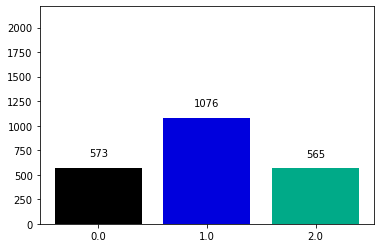

In [217]:
# count members per cluster
cluster_member_counts = df_km.groupby([cluster_column]).agg({cluster_column:['count']})
cluster_member_counts.columns = cluster_member_counts.columns.droplevel(0)

# plot counts
plt.bar(
  cluster_member_counts.index,
  cluster_member_counts['count'],
  color = cluster_colors,
  tick_label=cluster_member_counts.index
  )

# stretch y-axis
plt.ylim(0,df_km.shape[0])

# labels
for index, value in zip(cluster_member_counts.index, cluster_member_counts['count']):
    plt.text(index, value, str(value)+'\n', horizontalalignment='center', verticalalignment='baseline')

In [218]:
df_cluster_summary = df_km.groupby('cluster').mean().T.reset_index()
df_cluster_summary = df_cluster_summary.rename(columns={'level_0':'column','level_1':'metric'})
df_cluster_summary

cluster                      index           0.0           1.0           2.0
0                        Education      0.961606      0.971136      0.966372
1                   Marital_Status      0.347295      0.339851      0.391150
2                           Income  41440.481675  54530.232775  59010.930973
3                          Recency     48.139616     50.740223     46.709735
4                NumWebVisitsMonth      6.127400      5.069832      4.923894
5                         Complain      0.015707      0.006518      0.008850
6                              age     50.989529     53.931099     53.916814
7                        has_child      0.633508      0.354749      0.330973
8                      total_spend    300.158813    634.506518    868.665487
9                  total_purchases      8.326353     13.753259     14.612389
10            purchases_with_deals      0.302666      0.241445      0.202160
11           web_purchase_fraction      0.337404      0.329485      0.320329
12       catalog_purchase_fraction      0.073513      0.186663      0.216303
13         store_purchase_fraction      0.585592      0.481989      0.463368
14                 promos_accepted      0.284468      0.182495      1.122124
15                          tenure   3101.855148   3120.516760   3103.238938